In [39]:
import os
import numpy as np
import sys
import h5py
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../heart_rhythm_analysis'))    # make repo root importable

from heart_rhythm_analysis.get_data.CapnoBaseETL import CapnoBaseETL
from heart_rhythm_analysis.get_data.MimicAFETL import MimicAFETL


In [40]:
def load_as_df(file_path, filename, store_signals=True, bPlot=True):
    import h5py
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    h5_path = f"{file_path}/{filename}.h5"
    hf = h5py.File(h5_path, "r")

    rows = []
    for subj in hf.keys():
        subj_grp = hf[subj]
        for win_id in subj_grp.keys():
            win_grp = subj_grp[win_id]
            rec_id = win_grp.attrs['rec_id']
            label = win_grp.attrs['label']
            raw_ppg = win_grp["raw_ppg"][:]
            proc_ppg = win_grp["proc_ppg"][:]
            raw_ekg = win_grp["raw_ekg"][:]
            ekg_fs = win_grp.attrs["ekg_fs"]
            ppg_fs = win_grp.attrs["ppg_fs"]
            notes = win_grp.attrs["notes"]
            row_data = {
                "subject": subj,
                "window_id": win_id,
                "rec_id": rec_id,
                "label": label,
                "ppg_fs_out": ppg_fs,
                "ekg_fs_out": ekg_fs,
                "raw_len": len(raw_ppg),
                "proc_len": len(proc_ppg),
                "duration_raw_s": len(raw_ppg) / ppg_fs,
                "duration_proc_s": len(proc_ppg) / ppg_fs,
                "notes": notes
            }
            if store_signals:
                row_data["raw_ppg"] = raw_ppg
                row_data["proc_ppg"] = proc_ppg
                row_data["raw_ekg"] = raw_ekg            
            rows.append(row_data)

    df = pd.DataFrame(rows)
    print(f"\nTotal windows: {len(df)}")
    if bPlot:
        first = df.iloc[np.random.randint(0, len(df))]
        y = first["proc_ppg"]
        t = np.arange(len(y)) / first.ppg_fs_out

        notes = first['notes']
        print(notes)
        fig = plt.figure(figsize=(15,7))
        plt.subplot(211)
        plt.plot(t, y)
        plt.title(f"Subject {first.subject} – Window {first.window_id}\nfs={first.ppg_fs_out} Hz")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.xlim(0,10)

        plt.subplot(212)
        y = first["raw_ekg"]
        t = np.arange(len(y)) / first.ekg_fs_out
        plt.plot(t,y)
        plt.title(f"fs={first.ekg_fs_out} Hz")
        plt.xlim(0,10)
        plt.tight_layout()
        plt.show()
    hf.close()
    return df

# Create Capno Dataset

In [ ]:
# %autoreload 2



def main():
    root_path = os.path.join('../data/raw/capnobase/data/mat')
    out_path = os.path.join('../data/processed/length_full/capnobase_db')
    out_filename = 'capnobase_db'
    if not os.path.exists(out_path):
        os.mkdir(out_path)

    fs_in = 100.00
    fs_out = 20.83

    config = {
    "input_dir"      : root_path,
    "output_dir"     : out_path,
    "window_size_sec": 30,
    "fs_in"          : fs_in,
    "fs_out"   : fs_out,
    "lowpass_cutoff" : (fs_out / 2),
    "fir_numtaps"    : 129,
    "zero_phase"     : True,
    "out_filename" :  out_filename
}
    cfg = {'input_dir': root_path, 'output_dir': out_path}
    etl = CapnoBaseETL(config)
    h5file = etl.process_all()
    print(f"Saved windows HDF5 to {h5file}")
    df = load_as_df(out_path,out_filename)

    display(df.head(10))
    return df
if __name__ == "__main__":
    df_capnobase = main()

# MIMIC III AF DATASET

In [ ]:

def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_af_data.mat')
    out_filename = 'mimic_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "out_filename": out_filename
    }
    
    etl = MimicAFETL(config)
    out_file = etl.process()
    print("Saved AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df

if __name__ == "__main__":
    df_mimc_af = main()
    

# MIMIC III Non-AF Dataset

In [ ]:
def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_non_af_data.mat')
    out_filename = 'mimic_non_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_non_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "out_filename": out_filename   
    }

    etl = MimicAFETL(config)
    out_file = etl.process()
    print("Saved non AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimc_nonaf = main()

# MIMIC III Ethnicity Subset

In [ ]:
def main():
    root_path = os.path.join('../data/raw/mimic_ethnicity_data/mimic_ethnicity_struct_output.mat')
    out_filename = 'mimic_ethnicity_db'
    out_path = os.path.join('../data/processed/length_full/mimic_ethnicity_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "out_filename": out_filename 
    }
    
    etl = MimicAFETL(config)
    out_file = etl.process()
    print("Saved General MIMIC III - Ethnicity windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic_gen = main()

In [ ]:
all_subjects = df_mimic_gen['subject'].unique()
all_subjects

In [ ]:
df_capnobase['subject'].unique()
df_mimc_nonaf['subject'].unique()
df_mimc_nonaf['subject'].unique()
df_mimic_gen['subject'].unique()

# MIMIC IV AFib Data

Loading ../data/raw/mimic4_data/tmimic4_sinus_rhythm_struct.mat
Saved sinus_rhythm MIMIC IV  windows to ../data/processed/length_full/tmimic4_sinus_rhythm_db/tmimic4_sinus_rhythm_db.h5

Total windows: 1800



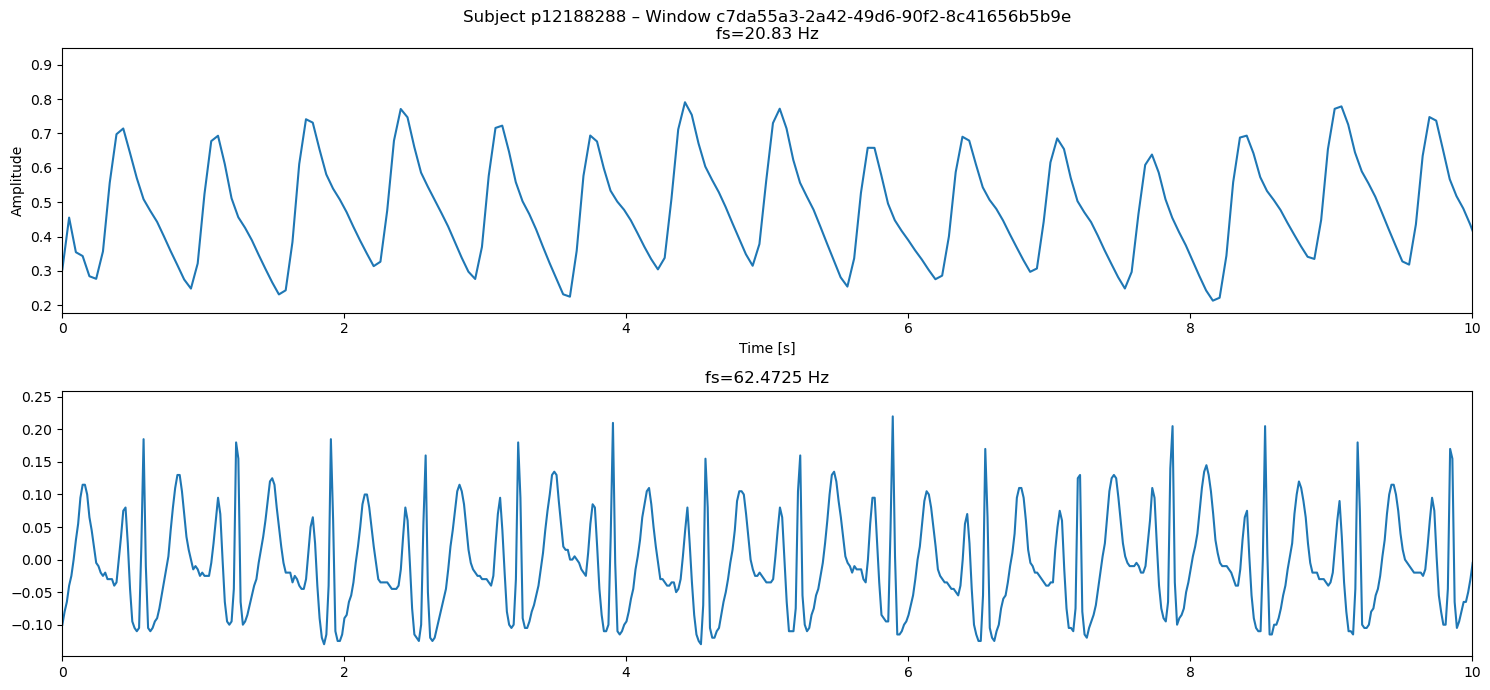

,subject,window_id,rec_id,label,ppg_fs_out,ekg_fs_out,raw_len,proc_len,duration_raw_s,duration_proc_s,notes,raw_ppg,proc_ppg,raw_ekg
0,p10014354,07da047f-3ccb-4588-aff7-dbe2e9aa7dd2,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.547607421875, 0.547119140625, 0.54638671875...","[0.3649686, 0.5885399, 0.5204258, 0.55280447, ...","[0.075, 0.035, 0.005, 0.015, 0.025, -0.01, -0...."
1,p10014354,08a6f005-3497-4595-b729-fb0fe565881c,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.45849609375, 0.440673828125, 0.42724609375,...","[0.30000412, 0.45440423, 0.38491634, 0.4037206...","[-0.02, 0.005, -0.015, -0.03, -0.05, -0.06, -0..."
2,p10014354,08d5d907-ff15-4178-a30d-340906e57d9f,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.548095703125, 0.618896484375, 0.68408203125...","[0.3875511, 0.765595, 0.70486563, 0.62474275, ...","[-0.02, -0.035, -0.055, -0.06, -0.055, 0.13, 0..."
3,p10014354,123c4b13-b92a-4771-9861-70c82c2791f5,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.50244140625, 0.5029296875, 0.497802734375, ...","[0.3357277, 0.52777416, 0.41311792, 0.39829478...","[0.035, 0.055, 0.075, 0.11, 0.17, 0.235, 0.27,..."
4,p10014354,148222df-4f31-4c8a-b3f2-cd907cce0f16,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.685791015625, 0.699951171875, 0.70336914062...","[0.4630651, 0.75007117, 0.6091565, 0.5650815, ...","[0.025, 0.025, 0.03, 0.05, 0.07, 0.085, 0.09, ..."
5,p10014354,1957968c-fab8-4a2b-8c91-8b90fceb39c3,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.393798828125, 0.392578125, 0.393310546875, ...","[0.2620312, 0.42668915, 0.39063317, 0.4185762,...","[-0.13, -0.145, -0.165, -0.17, -0.155, -0.02, ..."
6,p10014354,1ab8691d-8711-4c32-ae60-5facb3bfb898,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.67333984375, 0.701416015625, 0.7109375, 0.7...","[0.45913893, 0.7608165, 0.6182488, 0.5647195, ...","[-0.04, 0.25, 0.06, -0.2, -0.125, -0.045, 0.04..."
7,p10014354,1b22e90f-12c9-4008-86ab-1b62dd95c0e7,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.43212890625, 0.41748046875, 0.40771484375, ...","[0.2833618, 0.43712032, 0.39212346, 0.42990726...","[-0.07, -0.105, -0.13, -0.145, -0.155, -0.175,..."
8,p10014354,1f0b6746-0854-4106-8648-49588ace4c62,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.270751953125, 0.283935546875, 0.296875, 0.3...","[0.18424918, 0.32758158, 0.30165198, 0.3074999...","[0.02, 0.025, 0.035, 0.05, 0.06, 0.055, 0.045,..."
9,p10014354,21d341a2-5fa4-48b1-9928-4a88e61a178b,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,,"[0.523193359375, 0.541259765625, 0.55078125, 0...","[0.35476112, 0.5951204, 0.50644815, 0.4867497,...","[-0.015, -0.005, 0.015, 0.055, 0.125, 0.225, 0..."


In [43]:
from heart_rhythm_analysis.get_data.MimicAFETL import MimicAFETL
np.random.seed(42)
def main():
    substring = 'sinus_rhythm'
    root_path = os.path.join(f'../data/raw/mimic4_data/tmimic4_{substring}_struct.mat')
    out_filename = f'tmimic4_{substring}_db'
    out_path = os.path.join(f'../data/processed/length_full/{out_filename}')

    if not os.path.exists(out_path):
        os.mkdir(out_path)
    fs_in = 62.4275
    fs_out = 20.83
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": fs_in,
        "fs_out": fs_out,
        "window_size_sec": 30,
        "scale_type": None,
        "decimate_signal": None,
        "zero_phase": True,
        "out_filename": out_filename 
    }
    
    etl = MimicAFETL(config)
    out_file = etl.process()
    print(f"Saved {substring} MIMIC IV  windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic_gen = main()
